In [13]:
%load_ext autoreload
%autoreload 2

import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from generate_image import get_images_from_map, get_cells_from_map


import jax
import jax.numpy as jnp
import jax.random as jr
import jax_dataloader as jdl
from jaxili.inference import NPE, NLE

import numpyro.distributions as dist

from neural_compression import NeuralCompressor
from neural_compression import get_simulations, get_datasets
from neural_compression import CompressionCNN

import matplotlib.pyplot as plt
from getdist import plots, MCSamples
%matplotlib inline

print("Device used by jax:", jax.devices())

from jaxili.utils import create_data_loader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device used by jax: [CpuDevice(id=0)]


In [14]:
num_sim = 1
rot_i = 0
rot_j = 0
noise_real = 0
# path_output = f'/lustre/fswork/projects/rech/prk/uid35yw/test_gss/forward_model_sim{num_sim:05d}_nside0512_rot{rot_i}{rot_j}_noisereal{noise_real}.npy'
# path_output = f'/n17data/sguerrini/GowerStreetSims/processed/forward_model_sim{num_sim:05d}_nside0512_rot{rot_i}{rot_j}_noisereal{noise_real}.npy'
path_output = f'/n17data/mmaupas/processedSims/forward_model_sim{num_sim:05d}_nside0512_rot{rot_i}{rot_j}_noisereal{noise_real}.npy'
output = np.load(path_output, allow_pickle=True).item()

In [15]:

#Checking the power spectrum of the convergence and shear fields
#Load parameters for the cosmology
h = output['cosmo_params']["h"]
Om = output['cosmo_params']["Omega_m"]
Ob = output['cosmo_params']["Omega_b"]
Oc = Om - Ob
ns = output['cosmo_params']["n_s"]
m_nu = output['cosmo_params']["m_nu"]
w = output['cosmo_params']["w"]
As = output['cosmo_params']["A_s"]

nside = output['config']['preprocessing']['nside']
lmax = 2*nside

sim_cls = output['bin_1']['cl_FS_gamma']


blank_pixels = 0#hp.UNSEEN
n_ref = 1
master_key = jax.random.PRNGKey(0)
path_output = '/n17data/mmaupas/processedSims/'

selected_images = {1: [5],#[1,2,3,5],
                2: [4, 5, 6, 7, 9, 10, 11, 14, 22, 27, 31]
                }


/home/maupas/.local/lib/python3.12/site-packages/healpy/projector.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  img[w] = mpix


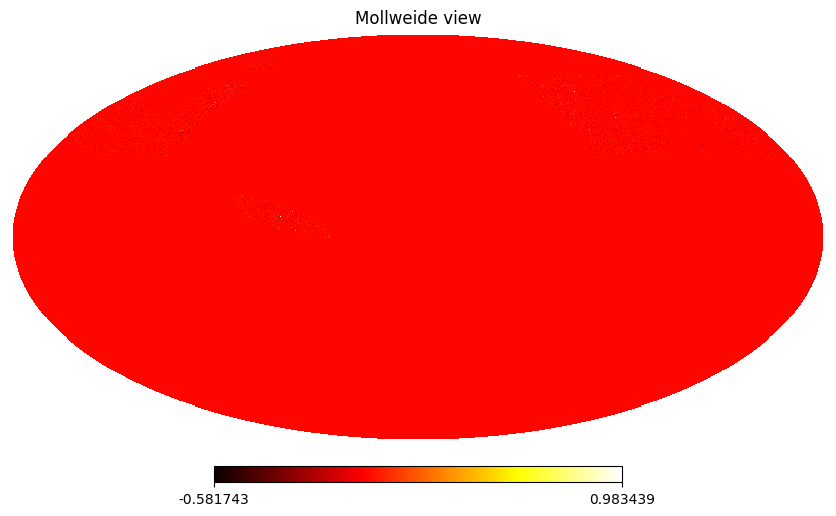

In [16]:
idx_gal = output['bin_1']['idx']

shear_map = np.full(hp.nside2npix(nside), blank_pixels, dtype=np.complex128)
shear_map[idx_gal] = output['bin_1']['masked_shear_map'] + output['bin_1']['noise_map']
shear_map_sub = np.copy(shear_map)

im = get_images_from_map(nside, shear_map_sub.real, blank_pixels=blank_pixels)

hp.mollview(shear_map_sub, cmap='hot')

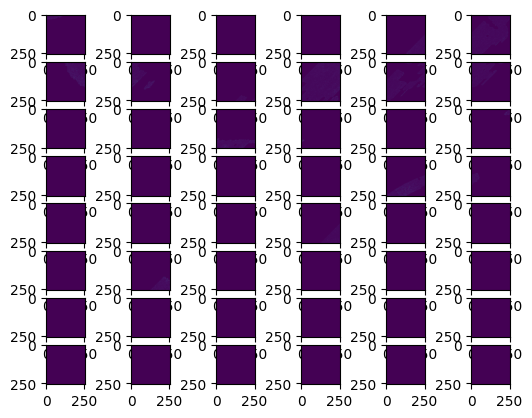

In [17]:
im = np.abs(get_cells_from_map(nside, shear_map, map_ordering='RING', n_ref=2))
for i in range(im.shape[0]):
    subplot = plt.subplot(4*2, 3*2, i+1)

    plt.imshow(im[i], cmap='viridis', vmin=0, vmax=1)
    # plt.colorbar()
plt.show()

## Loading data

In [18]:
pixels, cls, theta = get_simulations(path_output, sims=[1, 2], rot_is=[0,1,2,3,4], rot_js=[0,1,2,3,4], noise_reals=2, selected_images=selected_images[n_ref])
# pixels, cls, theta = get_simulations('/n17data/mmaupas/processedSims/', sims=[1, 2], rot_is=[0, 1, 2, 3, 4], rot_js=[0, 1, 2, 3, 4], noise_reals=2, selected_images=selected_images[n_ref])

  0%|          | 0/100 [00:00<?, ?it/s]

Loaded 100 simulations


In [19]:
x = pixels
# x = cls
# x = jnp.concatenate([pixels, cls], axis=1)

repeat = 1
theta = theta.repeat(repeat, axis=0)
x = x.repeat(repeat, axis=0)

x.shape, theta.shape

((100, 524288), (100, 2))

In [20]:
jnp.unique(theta, axis=0)

Array([[0.7657514 , 0.2900405 ],
       [0.95049614, 0.24962875]], dtype=float32)

In [21]:
x_compression, x_inference = x, x
theta_compression, theta_inference = theta, theta


# key = jr.PRNGKey(np.random.randint(0, 1000))
# num_sims = x.shape[0]
# index_permutation = jr.permutation(key, num_sims)
# compression_idx = index_permutation[: int(0.5 * num_sims)]
# inference_idx = index_permutation[int(0.5 * num_sims):]
# x_compression, x_inference = x[compression_idx], x[inference_idx]
# theta_compression, theta_inference = theta[compression_idx], theta[inference_idx]

## MSE/MAE


In [22]:
def MSE(model, params, batch):
    return model.apply({"params": params}, *batch, method=model.MSE)

def MAE(model, params, batch):
    return model.apply({"params": params}, *batch, method=model.MAE)

model_hparams = {
    "num_hiddens": [],
    "output_size": theta.shape[-1],
    
    "num_images": len(selected_images[n_ref]),
    "n_ref": n_ref,
    "nside": nside,
}

train_dataloader, valid_dataloader, test_dataloader = create_data_loader(
    *get_datasets(x_compression, theta_compression, jnp.array([70, 15, 15])), 
    train=[True, False, False],
    batch_size=10,
)

optimizer_hparams = {
    'warmup': 0,
    'decay_steps': 5,
    'lr': 0.0001
}

CHECKPOINT_PATH = os.path.abspath("./checkpoints")
logger_params = {
    "log_dir": os.path.join(CHECKPOINT_PATH, "Compressor/"),
}

exmp_input = (
    jnp.ones((1, x_compression.shape[-1])),
    # jnp.zeros((theta_compression.shape[-1])),
)

Training set: 70 simulations.
Validation set: 15 simulations.
Test set: 15 simulations.


In [23]:
neural_compressor = NeuralCompressor(CompressionCNN, model_hparams, optimizer_hparams, loss_fn=MSE, exmp_input=exmp_input, logger_params=logger_params)

neural_compressor.load_model()
print(f"Initial loss: {neural_compressor.eval_model(test_dataloader)["loss"]}")
# metrics_MSE = neural_compressor.train_model(train_loader=train_dataloader, val_loader=valid_dataloader, num_epochs=10)
# print(f"Final loss: {neural_compressor.eval_model(test_dataloader)["loss"]}")


                             CompressionCNN Summary                             
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path    ┃ module         ┃ inputs         ┃ outputs         ┃ params         ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│         │ CompressionCNN │ float32[1,524… │ float32[1,2]    │                │
├─────────┼────────────────┼────────────────┼─────────────────┼────────────────┤
│ Conv_0  │ Conv           │ float32[1,512… │ float32[1,512,… │ bias:          │
│         │                │                │                 │ float32[64]    │
│         │                │                │                 │ kernel:        │
│         │                │                │                 │ float32[5,5,1… │
│         │                │                │                 │                │
│         │                │                │                 │ 3,264 (13.1    │
│         │                

Initial loss: 0.07947088032960892


In [24]:
compressor_MSE = neural_compressor.bind_model()

## VMIM

In [25]:
model_hparams = {
    "num_hiddens": [],
    "output_size": theta_compression.shape[-1],

    "num_images": len(selected_images[n_ref]),
    "n_ref": n_ref,
    "nside": nside,
}

optimizer_hparams = {
    'optimizer_name': 'adam',
    'gradient_clip': 4.0,
    'warmup': 0,
    'weight_decay': 0.0,
}

VMIM = NPE()
VMIM = VMIM.append_simulations(theta_compression, x_compression)

CHECKPOINT_PATH = os.path.abspath("./checkpoints")

metrics_VMIM, density_estimator = VMIM.train(
    learning_rate=1e-6,
    training_batch_size=10,
    checkpoint_path=CHECKPOINT_PATH,
    num_epochs=2,
    embedding_net=CompressionCNN(**model_hparams),
    **optimizer_hparams,
)

[!] Inputs are valid.
[!] Appending 100 simulations to the dataset.
[!] Dataset split into training, validation and test sets.
[!] Training set: 70 simulations.
[!] Validation set: 19 simulations.
[!] Test set: 11 simulations.
[!] Creating DataLoaders with batch_size 10.
[!] Building the neural network.
[!] Creating the Trainer module.
Could not tabulate model: 
[!] Training the density estimator.


Epochs: Val loss -3.448/ Best val loss -3.448: 100%|██████████| 2/2 [18:48<00:00, 564.02s/it]


[!] Training loss: -3.4466733932495117
[!] Validation loss: -3.448051929473877
[!] Test loss: -3.429447889328003


In [26]:
compressor_VMIM = density_estimator.embedding_net

## Inference

In [27]:
# compressor = compressor_MSE
compressor = compressor_VMIM
t_inference = compressor(x_inference)

optimizer_hparams = {
    'optimizer_name': 'adam',
    'gradient_clip': 4.0,
    'warmup': 0.1,
    'weight_decay': 0.0,

    # Early stopping
    'min_delta': 0.001,
    'patience': 30,
}

CHECKPOINT_PATH = os.path.abspath("./checkpoints")
inference = NLE()
inference = inference.append_simulations(theta_inference, t_inference)
metrics, density_estimator = inference.train(
    learning_rate=1e-5,
    training_batch_size=3,
    checkpoint_path=CHECKPOINT_PATH,
    num_epochs=200,
    **optimizer_hparams,
)

[!] Inputs are valid.
[!] Appending 100 simulations to the dataset.
[!] Dataset split into training, validation and test sets.
[!] Training set: 70 simulations.
[!] Validation set: 19 simulations.
[!] Test set: 11 simulations.
[!] Creating DataLoaders with batch_size 3.
[!] Building the neural network.
[!] Creating the Trainer module.
Could not tabulate model: 
[!] Training the density estimator.


Epochs: Val loss -2.434/ Best val loss -2.434:  16%|█▌        | 31/200 [00:04<00:25,  6.63it/s]


Neural network training stopped after 32 epochs.
Early stopping with best validation metric: -2.4338157176971436
Best model saved at epoch 28
Early stopping parameters: min_delta=0.001, patience=30
[!] Training loss: -2.4867024421691895
[!] Validation loss: -2.4339470863342285
[!] Test loss: -2.371919870376587


In [28]:
prior_distr = dist.Uniform(low=jnp.array([0., 0.1]), high=jnp.array([1., 0.7]))

posterior = inference.build_posterior(
    prior_distr=prior_distr
)

num_samples = 100
sample_key, master_key = jax.random.split(master_key)

i_obs = 52
obs_x = x[i_obs].reshape((1,-1))
obs_t = compressor(obs_x)
obs_theta = theta[i_obs].reshape((1,-1))
samples = posterior.sample(
    x=obs_t, num_samples=num_samples, key=sample_key
)

Using MCMC method: nuts_numpyro
MCMC kwargs: {}
[!] Posterior $p(\theta| x)$ built. The class MCMCPosterior is used to sample and evaluate the log probability.\n The sampling is performed using MCMC methods.


sample: 100%|██████████| 600/600 [00:03<00:00, 155.11it/s, 1 steps of size 9.01e-01. acc. prob=0.87]


In [29]:
labels = [
    r"\sigma_8",
    r"\Omega_m",
    # r"\Omega_b",
    # "h",
    # r"n_s",
    # r"m_nu",
    # "w",
    # r"A_s"
]

samples_gd = MCSamples(root="./", samples=samples, names=labels, labels=labels)

Removed no burn in


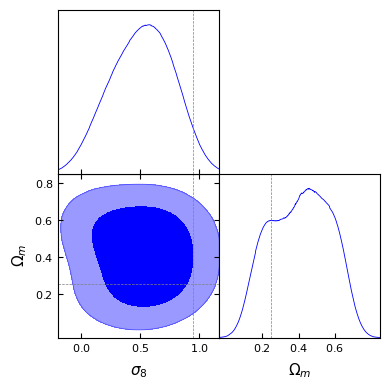

In [30]:
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot(
    [samples_gd], filled=True,
    line_args=[
        {'color': 'blue'}
    ],
    contour_colors=['blue'],
    markers={
        label: val for label, val in zip(labels, obs_theta[0])
    },
)
plt.show()

In [31]:
from IPython.display import display, Math, Markdown

stats = samples_gd.getMargeStats()

loglike = (samples_gd[r'\sigma_8']-1)**2/1.2**2/2
samples_gd.loglikes = np.zeros(samples_gd.numrows) 
samples_gd.reweightAddingLogLikes(loglike)
samples_gd.updateSettings({'contours': [0.68, 0.95]})

sigma8_low, sigma_high = samples_gd.twoTailLimits(r"\sigma_8", 0.68)
Omega0_low, Omeag0_high = samples_gd.twoTailLimits(r"\Omega_m", 0.68)

# sigma8_low, sigma_high = stats.parWithName(r'\sigma_8').limits[0].lower, stats.parWithName(r'\sigma_8').limits[0].upper
# Omega0_low, Omeag0_high = stats.parWithName(r'\Omega_m').limits[0].lower, stats.parWithName(r'\Omega_m').limits[0].upper

sigma8_mean, Omega0_mean = samples_gd.getMeans()
sigma8_MLE, Omega0_MLE = samples_gd.getLikeStats().parWithName(r'\sigma_8').bestfit_sample, samples_gd.getLikeStats().parWithName(r'\Omega_m').bestfit_sample

display(Math(rf"\sigma_8 = {sigma8_mean:.3f}^{{+{sigma_high-sigma8_mean:.3f}}}_{{-{sigma8_mean-sigma8_low:.3f}}}"))
display(Math(rf"\Omega_m = {Omega0_mean:.3f}^{{+{Omeag0_high-Omega0_mean:.3f}}}_{{-{Omega0_mean-Omega0_low:.3f}}}"))

display(Math(rf"\sigma_8 = {sigma8_MLE:.3f}^{{+{sigma_high-sigma8_MLE:.3f}}}_{{-{sigma8_MLE-sigma8_low:.3f}}}"))
display(Math(rf"\Omega_m = {Omega0_MLE:.3f}^{{+{Omeag0_high-Omega0_MLE:.3f}}}_{{-{Omega0_MLE-Omega0_low:.3f}}}"))

display(Markdown(rf"Real values: $\sigma_8 = {obs_theta[0,0]:.3f}$ $\Omega_m = {obs_theta[0,1]:.3f}$"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Real values: $\sigma_8 = 0.950$ $\Omega_m = 0.250$

In [32]:
print(samples_gd.getTable(limit=1).tableTex())

\begin{tabular} { l  c}

 Parameter &  68\% limits\\
\hline
{\boldmath$\sigma_8       $} & $0.54^{+0.29}_{-0.24}      $\\

{\boldmath$\Omega_m       $} & $0.41\pm 0.17              $\\
\hline
\end{tabular}


In [33]:
loglike = (samples_gd[r'\sigma_8']-1)**2/1.2**2/2
samples_gd.loglikes = np.zeros(samples_gd.numrows) 
samples_gd.reweightAddingLogLikes(loglike)
print(samples_gd.getLikeStats())

Best fit sample -log(Like) = 0.000408
Ln(mean 1/like) = 0.099298
mean(-Ln(like)) = 0.095222
-Ln(mean like)  = 0.091387
2*Var(Ln(like)) = 0.015823

parameter   bestfit        lower1         upper1         lower2         upper2
\sigma_8    9.6574080E-01  4.3118909E-01  9.6574080E-01  1.0830990E-01  9.6574080E-01   \sigma_8
\Omega_m    4.4753990E-01  1.1549812E-01  6.9550383E-01  1.1549812E-01  6.9607860E-01   \Omega_m

